In [1]:
# Copyright (C) 2023 qBraid
# Copyright (C) IBM
#
# This file is part of the qBraid-SDK.
#
# The qBraid-SDK is free software released under the GNU General Public License v3
# or later. This specific file, adapted from Qiskit, is dual-licensed under both the
# Apache License, Version 2.0, and the GPL v3. You may not use this file except in
# compliance with the applicable license. You may obtain a copy of the Apache License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file includes code adapted from Qiskit (https://github.com/Qiskit/qiskit-ibm-provider)
# with modifications by qBraid. The original copyright notice is included above.
# THERE IS NO WARRANTY for the qBraid-SDK, as per Section 15 of the GPL v3.

# qBraid-SDK Qiskit on AWS Device Demo: Bernstein-Vazirani Algorithm

Per usual, install the qBraid SDK environment on Lab, and use the qBraid CLI to enable [Quantum Jobs](https://docs.qbraid.com/en/latest/lab/quantumjobs.html):

In [2]:
!qbraid jobs enable qbraid_sdk

You have already enabled qBraid Quantum Jobs in the qbraid_sdk environment.


You can check that the `jobs` keyword next to the qBraid SDK environment is now green.

In [3]:
!qbraid envs list

# installed environments:
#
default                  jobs  /opt/.qbraid/environments/qbraid_000000
aws_braket               jobs  /home/jovyan/.qbraid/environments/aws_braket_kwx6dl
qbraid_sdk               jobs  /home/jovyan/.qbraid/environments/qbraid_sdk_9j9sjy



It's important to import the qBraid SDK only *after* you have enabled quantum jobs.

In [4]:
import qbraid

qbraid.__version__

'0.4.4.dev20230816194153'

## Creating the Circuit

In [5]:
from qiskit import QuantumCircuit

The code for this circuit was taken from IBMs Bernstein-Vazirani algorithm tutorial. Check out their [tutorial](https://www.youtube.com/watch?v=sqJIpHYl7oo) for a more in depth explanation. Classically, it takes n queries to decipher a secret string of length n – the Bernstein-Vazirani algorithm allows us to develop an oracle in a quantum circuit that is able to guess the string with just one query!

In [6]:
s = "110101"  # the number we hope to guess
n = len(s)

qiskit_circuit = QuantumCircuit(n + 1, n)

qiskit_circuit.x(n)
qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()

for ii, yesno in enumerate(reversed(s)):
    if yesno == "1":
        qiskit_circuit.cx(ii, n)

qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()
qiskit_circuit.measure(range(n), range(n))

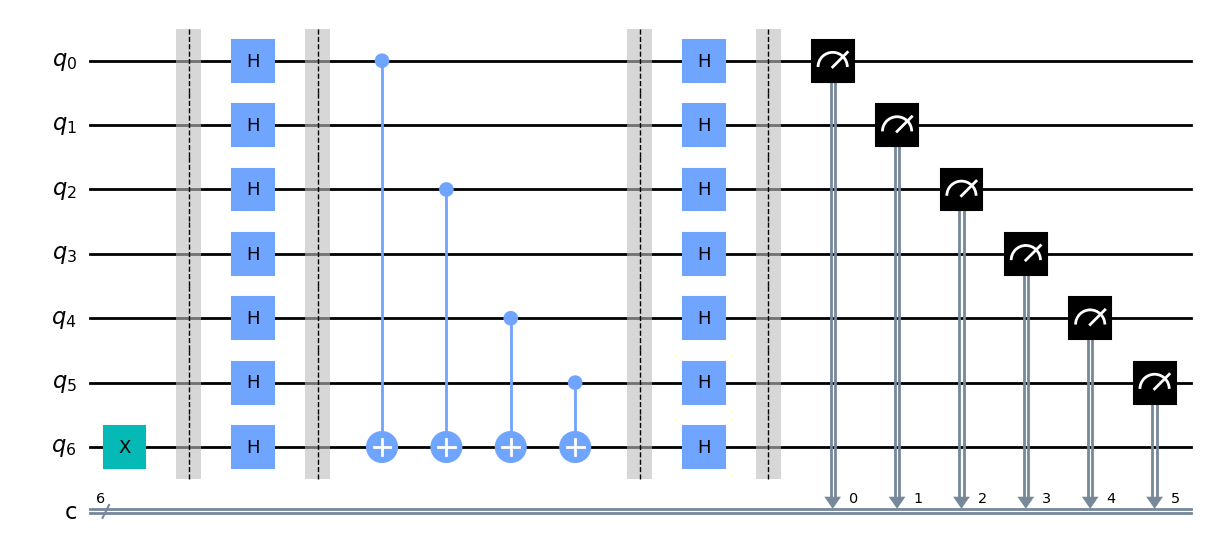

In [7]:
%matplotlib inline
qiskit_circuit.draw(output="mpl")  # Visualizing the circuit

## Running on an AWS Device via qBraid

Let's check which devices (specifically AWS ones) are online, and also find their device IDs:

In [8]:
from qbraid import get_devices

In [9]:
get_devices(filters={"vendor": "AWS"})

Provider,Name,qBraid ID,Status
AWS,DM1,aws_dm_sim,●
AWS,SV1,aws_sv_sim,●
AWS,TN1,aws_tn_sim,●
IonQ,Aria-1,aws_ionq_aria1,●
IonQ,Harmony,aws_ionq_harmony,●
OQC,Lucy,aws_oqc_lucy,○
QuEra,Aquila,aws_quera_aquila,○
Rigetti,Aspen-M-2,aws_rigetti_aspen_m2,○
Rigetti,Aspen-M-3,aws_rigetti_aspen_m3,○
Xanadu,Borealis,aws_xanadu_borealis,○


While we're at it, let's check how many credits we have left:

In [10]:
!qbraid jobs get-credits

You have 920.00 remaining qBraid credits.


In this tutorial we'll use Amazon's SV1 computer, since we see that it's online. Now we can use qBraid's [device wrapper](https://docs.qbraid.com/en/latest/sdk/devices.html#device-wrapper) to run a job on an Amazon device. The device wrapper adds a layer of abstraction, allowing us to run a qiskit circuit on an AWS quantum computer. Note that there's no need for any sort of circuit wrapper here – we can plug the qiskit circuit directly into the wrapped device!

In [11]:
from qbraid import device_wrapper

In [12]:
aws_device_id = "aws_sv_sim"  # aws_sv_sim is the qBraid id for the SV1 Computer
device = device_wrapper(aws_device_id)

In [13]:
braket_job = device.run(qiskit_circuit, shots=100)
braket_job.status()  # checking the status of our job

<JobStatus.COMPLETED: 'job has successfully run'>

In [14]:
result = braket_job.result()
counts = result.measurement_counts()

The job has succesfully run!

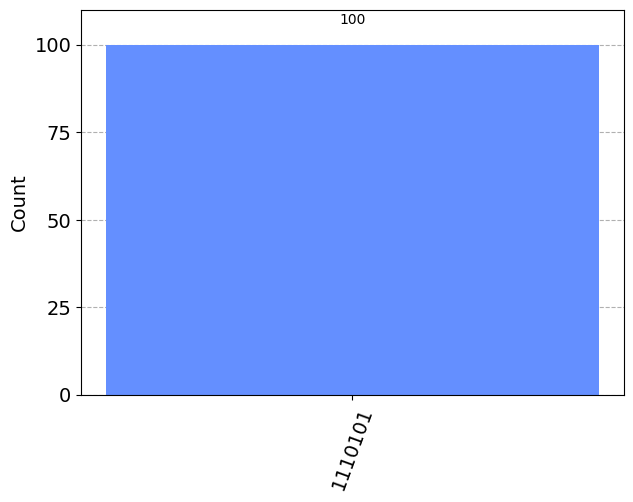

In [15]:
result.plot_counts()

In [16]:
keys = list(counts.keys())
values = list(counts.values())
for i in range(len(keys)):
    if values[i] > 0:
        print(keys[i], values[i])

# the preceding 1 is a fragment of the computation

1110101 100


In [17]:
# Printing the counts
print(counts)

{'1110101': 100}


We have guessed the number correctly! Note the bar graph where only one number was guessed in all 1000 shots

Finally we can estimate the cost of our job:

In [19]:
cost = braket_job.metadata()["cost"]
print(f"costEstimate: {cost} credits ~ ${cost/100}")

costEstimate: 0.400009555 credits ~ $0.00400009555
